In [ ]:
import numpy as np
import cv2
import os
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
import os
import pandas as pd
from shutil import copyfile

metadata_path = 'HAM10000_metadata.csv'
df = pd.read_csv(metadata_path)

df.head()

In [2]:

image_dir = 'HAM10000_IMAGES'
sorted_dir = 'sorted_image_directory'
os.makedirs(sorted_dir, exist_ok=True)

grouped = df.groupby('dx')

grouped.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
64,HAM_0001751,ISIC_0024698,nv,consensus,70.0,male,face
1095,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back
1096,HAM_0005276,ISIC_0028790,df,histo,75.0,male,back
1097,HAM_0004103,ISIC_0028880,df,histo,55.0,male,lower extremity
1098,HAM_0004103,ISIC_0031309,df,histo,55.0,male,lower extremity


In [3]:

for dx, group in grouped:
    sorted_group = group.sort_values(by='image_id')  
    selected_images = sorted_group.head(100)  
    

    dx_dir = os.path.join(sorted_dir, dx)
    os.makedirs(dx_dir, exist_ok=True)
    

    for _, row in selected_images.iterrows():
        src = os.path.join(image_dir, row['image_id'] + '.jpg')
        dst = os.path.join(dx_dir, row['image_id'] + '.jpg')
        copyfile(src, dst)

print("Images have been sorted and copied successfully.")

Images have been sorted and copied successfully.


In [5]:
from PIL import ImageOps


resized_dir_96 = 'resized_image_directory_96'
augmented_dir_96 = 'augmented_image_directory_96'


os.makedirs(augmented_dir_96, exist_ok=True)


for root, dirs, files in os.walk(resized_dir_96):
    for file in files:
        if file.endswith(".jpg"):
            img_path = os.path.join(root, file)
            img = Image.open(img_path)
            
            img_flipped = ImageOps.mirror(img)
            
            save_dir = root.replace(resized_dir_96, augmented_dir_96)
            os.makedirs(save_dir, exist_ok=True)
            img.save(os.path.join(save_dir, file))  
            flipped_file = file.replace(".jpg", "_flipped.jpg")
            img_flipped.save(os.path.join(save_dir, flipped_file))  

print("Horizontal flip augmentation applied successfully.")

Horizontal flip augmentation applied successfully.


In [30]:

dataset_dir = augmented_dir_96  # 

# Parameters
img_height, img_width = 96, 96
num_classes = 7  

def load_data(dataset_dir, img_height, img_width):
    images = []
    labels = []
    
    for disease in os.listdir(dataset_dir):
        disease_dir = os.path.join(dataset_dir, disease)
        if os.path.isdir(disease_dir):
            for img_name in os.listdir(disease_dir):
                img_path = os.path.join(disease_dir, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (img_width, img_height))
                img = img.astype('float32') / 255.0
                images.append(img)
                labels.append(disease)
                
    return np.array(images), np.array(labels)


images, labels = load_data(dataset_dir, img_height, img_width)

In [31]:
labels.shape

(1400,)

In [32]:
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)


X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=26, stratify=labels)


datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2
)


In [24]:
cnn_model = Sequential([
    # First Conv2D layer
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),  
    Dropout(0.25),
    

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    

    Dense(7, activation='softmax') 
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

epochs = 150
batch_size = 32

F:\new_folder\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
cnn_model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
              epochs=epochs,
              validation_data=(X_test, y_test))


Epoch 1/150


F:\new_folder\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.2363 - loss: 3.2286 - val_accuracy: 0.1429 - val_loss: 3.8299
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 343ms/step - accuracy: 0.3516 - loss: 2.0666 - val_accuracy: 0.1429 - val_loss: 6.2745
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 354ms/step - accuracy: 0.3924 - loss: 1.9320 - val_accuracy: 0.1429 - val_loss: 6.2334
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 353ms/step - accuracy: 0.4707 - loss: 1.7154 - val_accuracy: 0.1429 - val_loss: 6.3808
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 362ms/step - accuracy: 0.4890 - loss: 1.5807 - val_accuracy: 0.1429 - val_loss: 7.6880
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 355ms/step - accuracy: 0.5020 - loss: 1.4840 - val_accuracy: 0.1429 - val_loss: 5.5865
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step - accuracy: 0.5481 - loss: 1.2901 - val_accuracy: 0.1821 - val_loss: 5.0746
Epoch 8/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 332ms/step - accuracy: 0.5659 - loss: 1.3434 - val_accuracy

In [26]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test, verbose=2)

y_pred_probs = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

if y_test.ndim > 1 and y_test.shape[1] > 1:  
    y_test = np.argmax(y_test, axis=1)

cnn_precision = precision_score(y_test, y_pred, average='weighted')
cnn_recall = recall_score(y_test, y_pred, average='weighted')
cnn_f1 = f1_score(y_test, y_pred, average='weighted')

print("\nCNN - Classification Report:")
print(classification_report(y_test, y_pred))


9/9 - 1s - 70ms/step - accuracy: 0.8393 - loss: 0.5551
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step

CNN - Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.88      0.80        40
           1       0.94      0.78      0.85        40
           2       1.00      0.72      0.84        40
           3       0.90      0.93      0.91        40
           4       0.67      0.75      0.71        40
           5       0.83      0.88      0.85        40
           6       0.90      0.95      0.93        40

    accuracy                           0.84       280
   macro avg       0.85      0.84      0.84       280
weighted avg       0.85      0.84      0.84       280



In [27]:
print(f"Accuracy: {cnn_accuracy:.4f}")
print(f"Precision: {cnn_precision:.4f}")
print(f"Recall: {cnn_recall:.4f}")
print(f"F1 Score: {cnn_f1:.4f}")

Accuracy: 0.8393
Precision: 0.8537
Recall: 0.8393
F1 Score: 0.8408


<h4>AIMING TO MITIGATE OVERFITTING FROM THE CLASSIFICATION MODEL</h4>

In [33]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2
)

cnn_model = Sequential([

    Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.25),
    

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    

    Conv2D(256, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

epochs = 150
batch_size = 32

history = cnn_model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
              epochs=epochs,
              validation_data=(X_test, y_test),
              callbacks=[reduce_lr, early_stop])

F:\new_folder\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150


F:\new_folder\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.2910 - loss: 5.0875 - val_accuracy: 0.1429 - val_loss: 5.9945 - learning_rate: 0.0010
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3387 - loss: 4.5311 - val_accuracy: 0.1500 - val_loss: 5.2812 - learning_rate: 0.0010
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3809 - loss: 4.3598 - val_accuracy: 0.1429 - val_loss: 7.2072 - learning_rate: 0.0010
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4056 - loss: 4.0328 - val_accuracy: 0.1393 - val_loss: 6.3386 - learning_rate: 0.0010
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4025 - loss: 4.0032 - val_accuracy: 0.1893 - val_loss: 5.2274 - learning_rate: 0.0010
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 997ms/step - accuracy: 0.4607 - loss: 3.6129 - val_accuracy: 0.1429 - val_loss: 6.5571 - learning_rate: 0.0010
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4777 - loss: 3.4454 - val_accuracy: 0.

In [34]:
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test, verbose=2)

y_pred_probs = cnn_model.predict(X_test)

y_pred = np.argmax(y_pred_probs, axis=1)


if y_test.ndim > 1 and y_test.shape[1] > 1: 
    y_test = np.argmax(y_test, axis=1)

cnn_precision = precision_score(y_test, y_pred, average='weighted')
cnn_recall = recall_score(y_test, y_pred, average='weighted')
cnn_f1 = f1_score(y_test, y_pred, average='weighted')

print("\nCNN - Classification Report:")
print(classification_report(y_test, y_pred))


9/9 - 2s - 204ms/step - accuracy: 0.8929 - loss: 0.7941
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step

CNN - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        40
           1       0.92      0.90      0.91        40
           2       0.75      0.82      0.79        40
           3       0.93      0.97      0.95        40
           4       0.82      0.78      0.79        40
           5       0.95      0.97      0.96        40
           6       0.91      1.00      0.95        40

    accuracy                           0.89       280
   macro avg       0.90      0.89      0.89       280
weighted avg       0.90      0.89      0.89       280



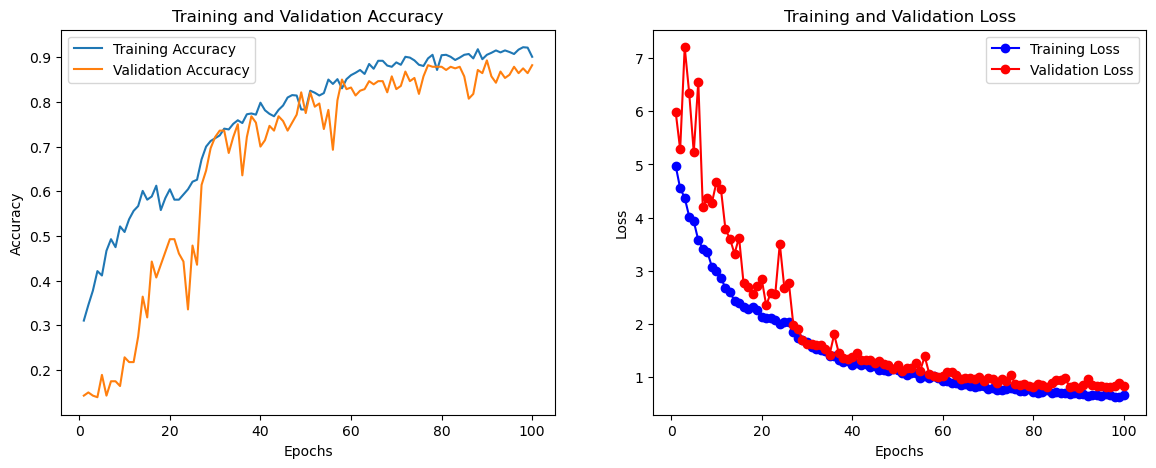

In [36]:
import matplotlib.pyplot as plt


def plot_training_history(history):
    # Extract data from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)


    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc,  label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


plot_training_history(history)